#### Import Libaries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path

from sklearn import metrics
import scipy
from scipy.cluster import hierarchy as hc

import shap
from eli5 import show_prediction, show_weights

import iml

from operator import itemgetter

from collections import defaultdict

import lightgbm as lgb
from xgboost import XGBRegressor

/usr/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Read and Split the Data

In [2]:
PATH = Path("data")
dataset = pd.read_csv(str(PATH)+"/bballdata.csv", encoding = 'latin_1').fillna(0)

In [3]:
dataset.shape

(3785, 8)

In [4]:
list(dataset.columns)

['Team',
 'Opponent',
 'Date',
 'Win',
 'OffAdjusted',
 'DefAdjusted',
 'OffAdjusted2',
 'DefAdjusted2']

In [5]:
Date = 2019

In [6]:
holdout = dataset.loc[(dataset.Date==Date)]
used = dataset.loc[((dataset.Date<Date))]

In [7]:
X = used.drop(['Win'], axis=1)
y = used['Win']

In [8]:
y.shape

(3784,)

In [9]:
y.sum()

1892.0

In [10]:
X_holdout = holdout.drop(['Win', 'Team', 'Opponent', 'Date'], axis=1)
y_holdout = holdout['Win']
bball_holdout = holdout[['Win', 'Team', 'Opponent', 'Date']]

In [11]:
y_holdout.shape

(1,)

In [12]:
y_holdout.sum()

0.0

In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [14]:
bball_X = X[['Team', 'Opponent', 'Date']]
bball_X_test = X_test[['Team', 'Opponent', 'Date']]

In [15]:
X = X.drop(['Team', 'Opponent', 'Date'], axis=1)
X_test = X_test.drop(['Team', 'Opponent', 'Date'], axis=1)

In [16]:
X.shape

(3405, 4)

#### Create and Train the XGBoost Model

In [17]:
# Fitting XGBoost to the Training set

regressor = XGBRegressor(max_depth=3, objective= 'binary:logistic', eval_metric = 'auc', missing=0, tree_method='gpu_hist')


In [18]:
regressor.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=0,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

In [19]:
metrics.roc_auc_score(y_test, regressor.predict(X_test))

0.7999888604210762

In [20]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [21]:
fi = rf_feat_importance(regressor,X);fi[:40]

,cols,imp
0,OffAdjusted,0.266026
3,DefAdjusted2,0.253205
2,OffAdjusted2,0.243590
1,DefAdjusted,0.237179


In [22]:
to_keep = fi[fi.imp>0.01].cols;len(to_keep)

4

In [23]:
X_keep = X[to_keep].copy()
X_test_keep = X_test[to_keep].copy()
X_keep_holdout = X_holdout[to_keep].copy()

In [24]:
regressor_keep = XGBRegressor(max_depth=3, objective= 'binary:logistic', eval_metric = 'auc', missing=0, tree_method='gpu_hist')

In [25]:
regressor_keep.fit(X_keep, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=0,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

In [26]:
metrics.roc_auc_score(y_test, regressor_keep.predict(X_test_keep))

0.7999888604210762

In [27]:
shap_values_keep_holdout = shap.TreeExplainer(regressor_keep).shap_values(X_keep_holdout)
shap_values_keep_test = shap.TreeExplainer(regressor_keep).shap_values(X_test_keep)

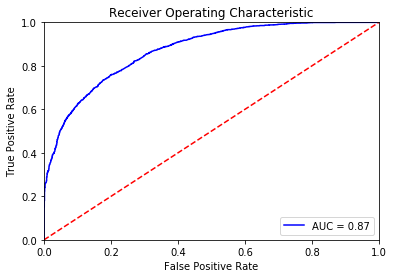

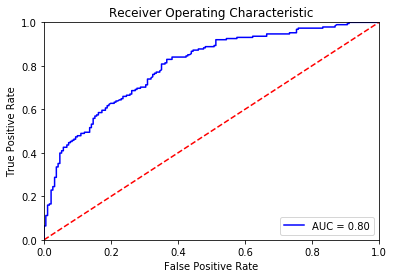

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [28]:
train_preds = regressor_keep.predict(X_keep)
train_auc_score = metrics.roc_auc_score(y, train_preds)
fpr, tpr, threshold = metrics.roc_curve(y,train_preds)
roc_auc_train = metrics.auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

test_preds = regressor_keep.predict(X_test_keep)
test_auc_score = metrics.roc_auc_score(y_test, test_preds)
fpr, tpr, threshold = metrics.roc_curve(y_test,test_preds)
roc_auc_test = metrics.auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

holdout_preds = regressor_keep.predict(X_keep_holdout)
holdout_auc_score = metrics.roc_auc_score(y_holdout, holdout_preds)
fpr, tpr, threshold = metrics.roc_curve(y_holdout,holdout_preds)
roc_auc_holdout = metrics.auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_holdout)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Train ROC: " + str(roc_auc_train) + " Test ROC: " + str(roc_auc_test) + " Holdout ROC: " + str(roc_auc_holdout))

In [29]:
holdoutdata = sorted(zip(holdout_preds, y_holdout), key=lambda x: x[0], reverse=True)
testdata = sorted(zip(test_preds,y_test), key=lambda x: x[0], reverse=True)

total=0
quit=0
quit1000=0
quit500=0
quit200=0
quit100=0
for i,j in holdoutdata:
    total+=1
    if(j==1):
        quit+=1
        if(total<=1000):
           quit1000+=1
        if(total<=500):
           quit500+=1
        if(total<=200):
           quit200+=1
        if(total<=100):
            quit100+=1
print("Total Holdout Size: "+ str(len(holdoutdata)))
print("Correct in top X/top X")
print("Top 1000: "+ str(quit1000/1000))
print("Top 500: "+ str(quit500/500))
print("Top 200: "+ str(quit200/200))
print("Top 100: "+ str(quit100/100))
print("Random: "+str(quit/len(holdoutdata)))
print("Correct in top X/Total Quits")
print("Top 1000: "+ str(quit1000/quit))
print("Top 500: "+ str(quit500/quit))
print("Top 200: "+ str(quit200/quit))
print("Top 100: "+ str(quit100/quit))
print("How much better than random?")
print("Top 1000 Lift: "+ str((quit1000/1000)/(quit/len(holdoutdata))))
print("Top 500 Lift: "+ str((quit500/500)/(quit/len(holdoutdata))))
print("Top 200 Lift: "+ str((quit200/200)/(quit/len(holdoutdata))))
print("Top 100 Lift: "+ str((quit100/100)/(quit/len(holdoutdata))))
print("Random Lift: "+str((quit/len(holdoutdata))/(quit/len(holdoutdata))))

print("")

total=0
quit=0
quit1000=0
quit500=0
quit200=0
quit100=0
for i,j in testdata:
    total+=1
    if(j==1):
        quit+=1
        if(total<=1000):
           quit1000+=1
        if(total<=500):
           quit500+=1
        if(total<=200):
           quit200+=1
        if(total<=100):
            quit100+=1
print("Total Test Size: "+ str(len(testdata)))
print("Correct in top X/top X")
print("Top 1000: "+ str(quit1000/1000))
print("Top 500: "+ str(quit500/500))
print("Top 200: "+ str(quit200/200))
print("Top 100: "+ str(quit100/100))
print("Random: "+str(quit/len(testdata)))
print("Correct in top X/Total Quits")
print("Top 1000: "+ str(quit1000/quit))
print("Top 500: "+ str(quit500/quit))
print("Top 200: "+ str(quit200/quit))
print("Top 100: "+ str(quit100/quit))
print("How much better than random?")
print("Top 1000 Lift: "+ str((quit1000/1000)/(quit/len(testdata))))
print("Top 500 Lift: "+ str((quit500/500)/(quit/len(testdata))))
print("Top 200 Lift: "+ str((quit200/200)/(quit/len(testdata))))
print("Top 100 Lift: "+ str((quit100/100)/(quit/len(testdata))))
print("Random Lift: "+str((quit/len(testdata))/(quit/len(testdata))))

Total Holdout Size: 1
Correct in top X/top X
Top 1000: 0.0
Top 500: 0.0
Top 200: 0.0
Top 100: 0.0
Random: 0.0
Correct in top X/Total Quits


ZeroDivisionError: division by zero

In [30]:
holdout_data = pd.DataFrame(columns=["Team", "Opponent", "Feature", "ForceAffect", "FeatureValue","Win", "PredictionPercent"])
counter = 0
for i in range(X_keep_holdout.shape[0]):
    Team = bball_holdout.Team.iloc[i]
    Opponent = bball_holdout.Opponent.iloc[i]
    features = X_keep_holdout.iloc[i,:]
    feature_names = list(features.index)
    display_features = features
    instance = iml.Instance(np.zeros((1, len(feature_names))), display_features)
    link=iml.links.convert_to_link('identity')
    out_names = ["output value"]
    e = iml.AdditiveExplanation(
        shap_values_keep_holdout[i, -1],
        np.sum(shap_values_keep_holdout[i, :]),
        shap_values_keep_holdout[i, :-1],
        None,
        instance,
        link,
        iml.Model(None, out_names),
        iml.DenseData(np.zeros((1, len(feature_names))), list(feature_names))
    )
    holdout_data = pd.concat([holdout_data,pd.concat([pd.DataFrame([[Team, Opponent, k, j, features[k], y_holdout.iloc[i], holdout_preds[i]]], columns=["Team", "Opponent", "Feature", "ForceAffect", "FeatureValue","Win", "PredictionPercent"]) for k,j in sorted(zip(e.data.group_names,e.effects),key=itemgetter(1))], ignore_index=True)],ignore_index=True)

    counter+=1
    if counter%1000==0:
        print(str(counter) +" out of "+str((X_keep_holdout.shape[0]))+" - "+str(round((counter/(X_keep_holdout.shape[0]))*100,2))+"%")      
print("Done!")

Done!


In [31]:
test_data = pd.DataFrame(columns=["Team", "Opponent", "Feature", "ForceAffect", "FeatureValue","Win", "PredictionPercent"])
counter = 0
for i in range(X_test_keep.shape[0]):
    Team = bball_X_test.Team.iloc[i]
    Opponent = bball_X_test.Opponent.iloc[i]
    features = X_test_keep.iloc[i,:]
    feature_names = list(features.index)
    display_features = features
    instance = iml.Instance(np.zeros((1, len(feature_names))), display_features)
    link=iml.links.convert_to_link('identity')
    out_names = ["output value"]
    e = iml.AdditiveExplanation(
        shap_values_keep_test[i, -1],
        np.sum(shap_values_keep_test[i, :]),
        shap_values_keep_test[i, :-1],
        None,
        instance,
        link,
        iml.Model(None, out_names),
        iml.DenseData(np.zeros((1, len(feature_names))), list(feature_names))
    )
    test_data = pd.concat([test_data,pd.concat([pd.DataFrame([[Team, Opponent, k, j, features[k], y_test.iloc[i], test_preds[i]]], columns=["Team", "Opponent", "Feature", "ForceAffect", "FeatureValue","Win", "PredictionPercent"]) for k,j in sorted(zip(e.data.group_names,e.effects),key=itemgetter(1))], ignore_index=True)],ignore_index=True)

    counter+=1
    if counter%1000==0:
        print(str(counter) +" out of "+str((X_test_keep.shape[0]))+" - "+str(round((counter/(X_test_keep.shape[0]))*100,2))+"%")      
print("Done!")

Done!


In [32]:
test_data.to_csv("bball_test_results_1.csv")

In [33]:
holdout_data.to_csv("holdout_bball1.csv")

In [34]:
from xgboost import plot_importance
from matplotlib import pyplot

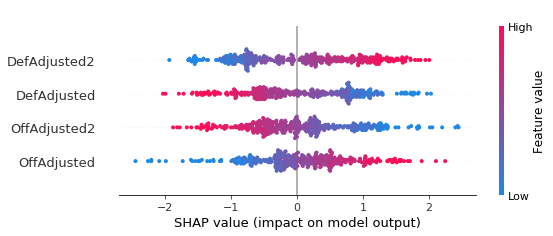

In [35]:
shap.summary_plot(shap_values_keep_test, X_test_keep)

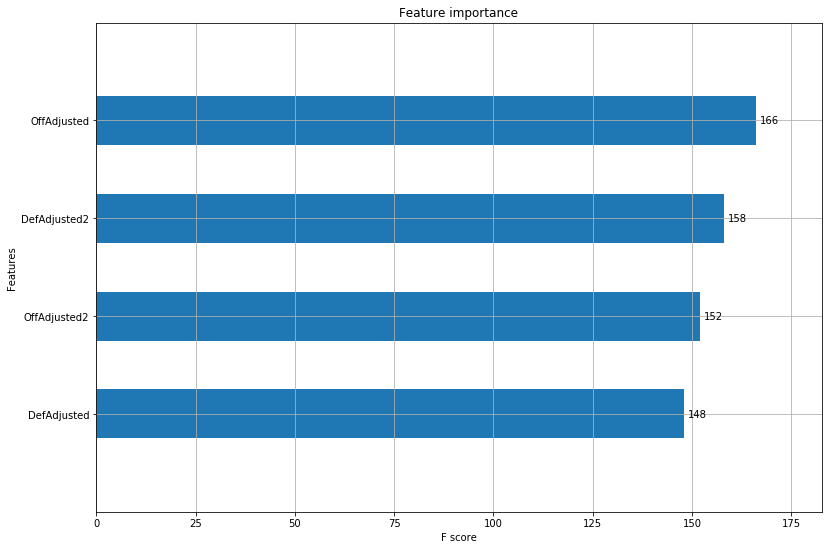

In [36]:
plot_importance(regressor_keep, ax=plt.subplots(figsize=(13,9))[1], height=0.5)
#pyplot.show(fi_plot)

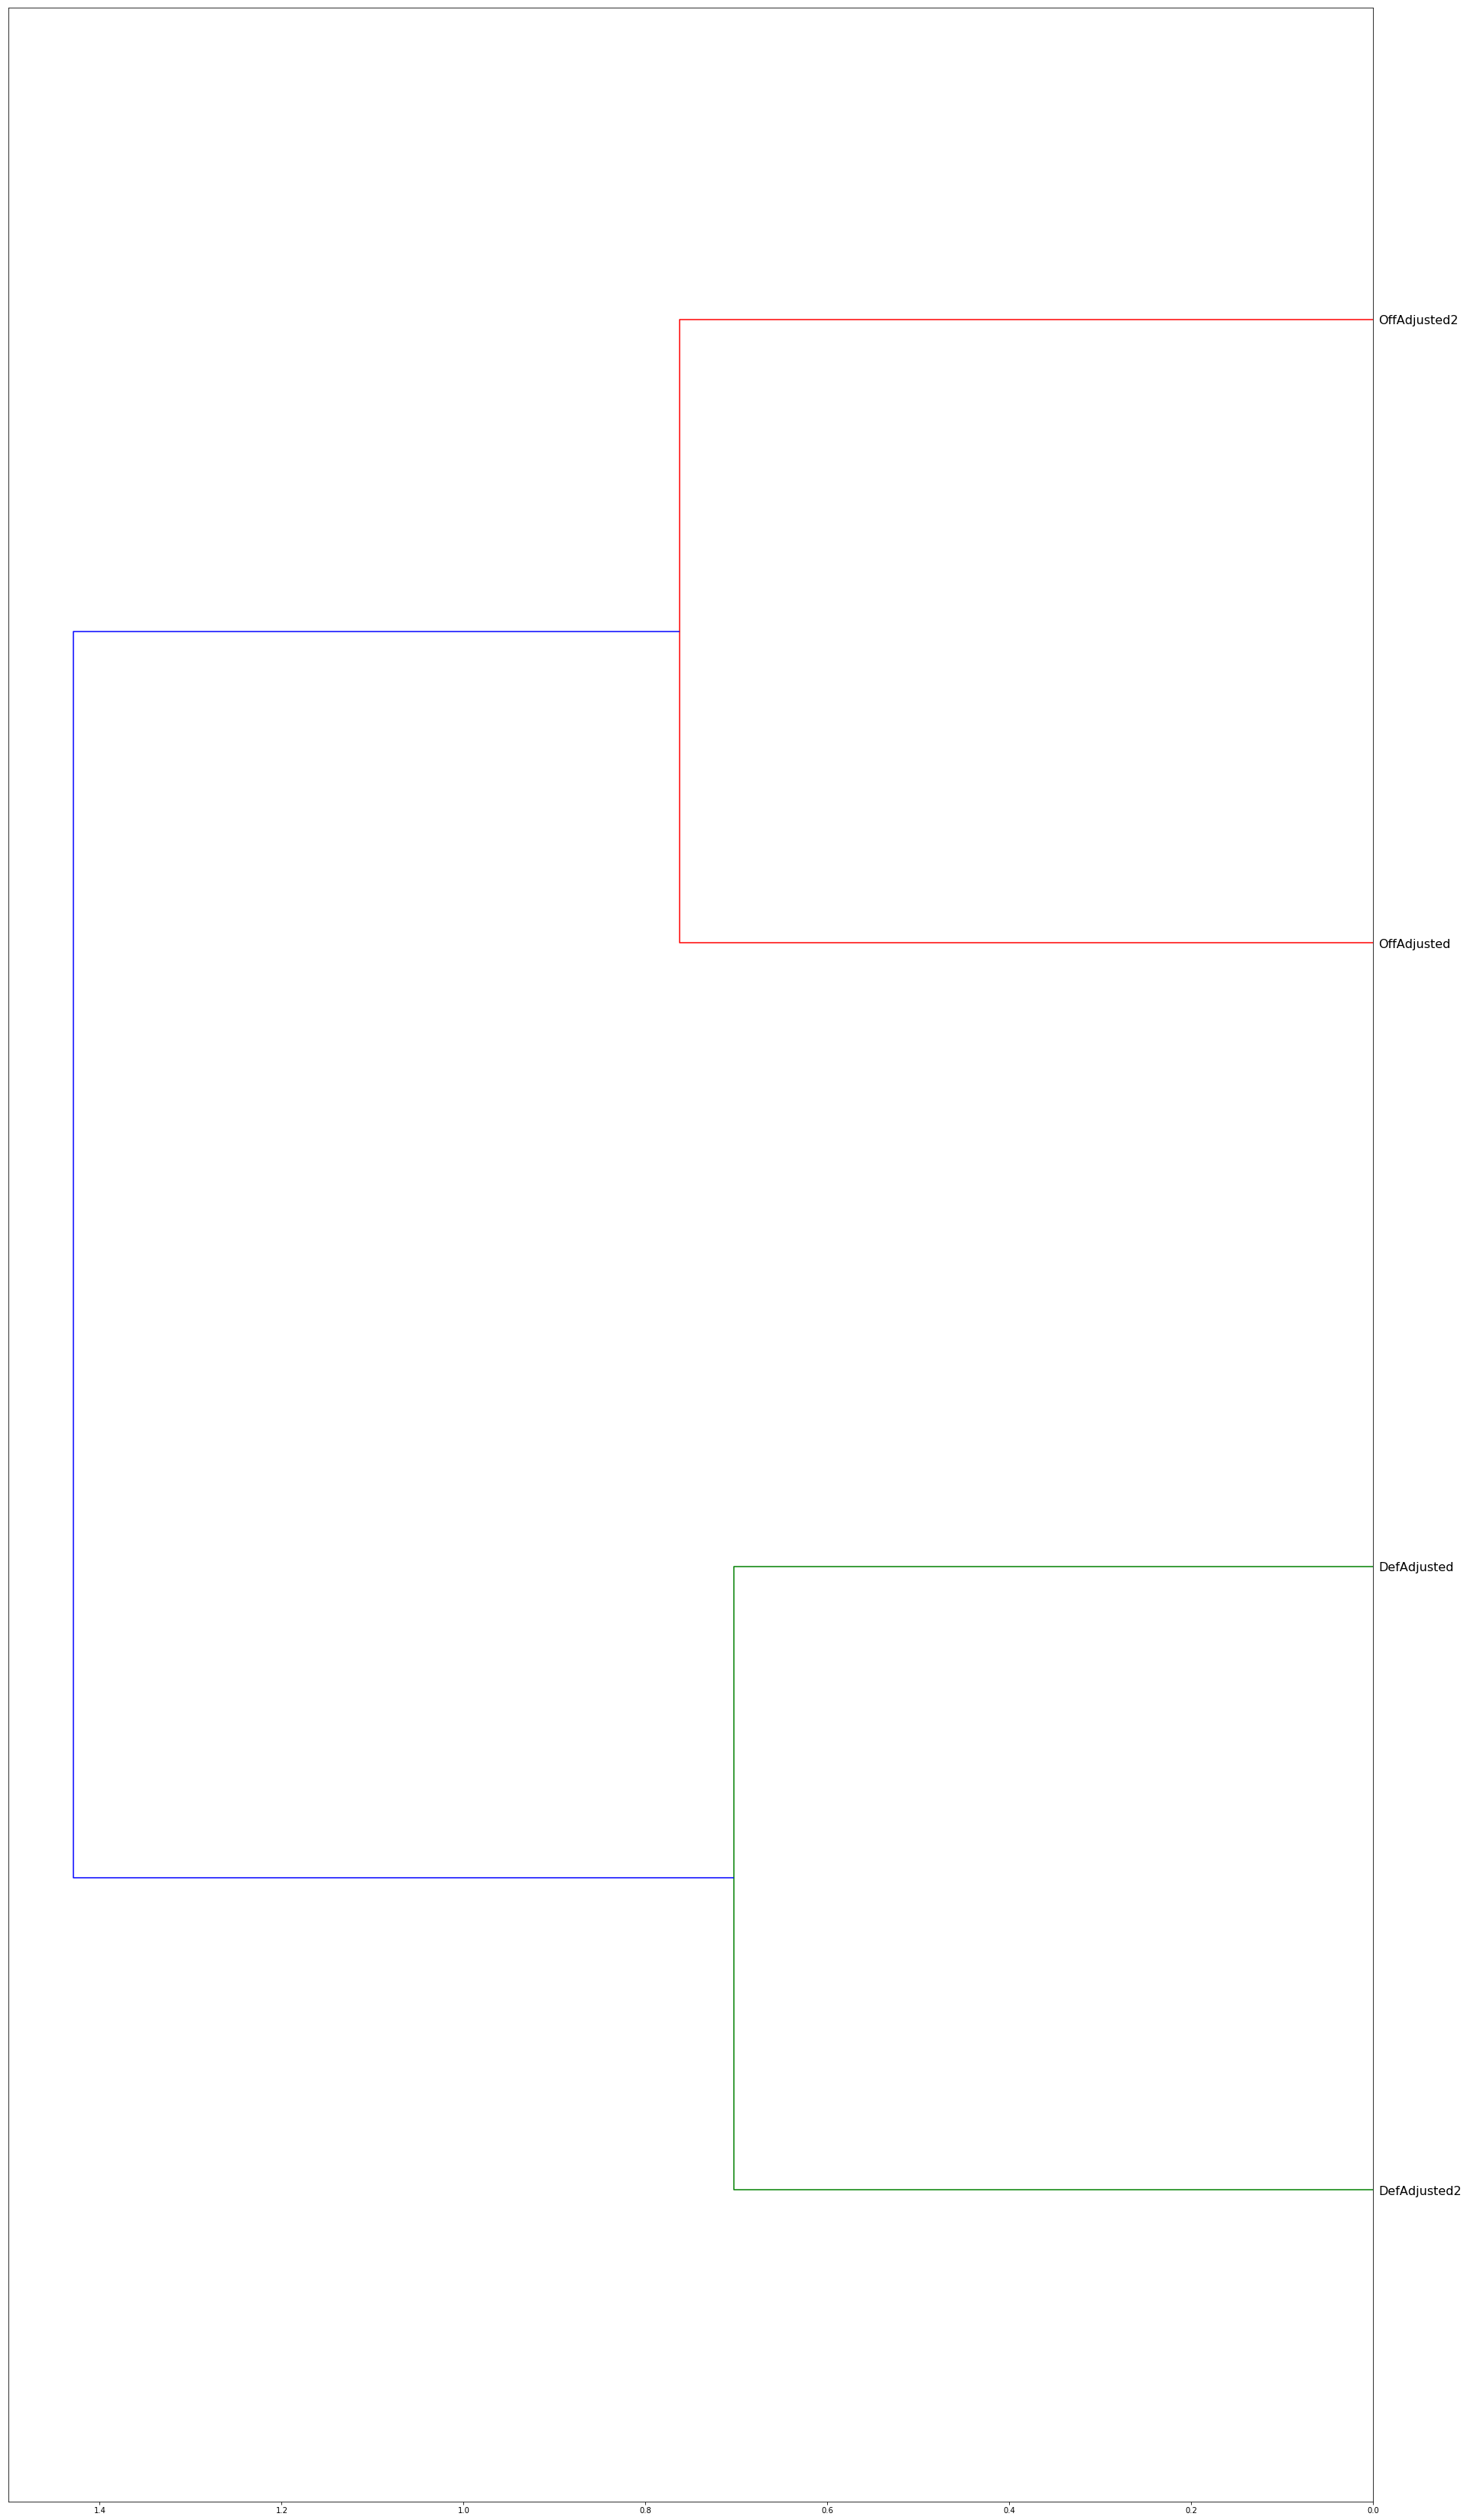

In [37]:
corr = np.round(np.nan_to_num(scipy.stats.spearmanr(X_keep, nan_policy="omit").correlation), 4)

corr_condensed = hc.distance.squareform(1-corr,checks=False)

z = hc.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(32,60))

dendogram = hc.dendrogram(z, labels=X_keep.columns, orientation='left', leaf_font_size=16)

plt.show()

#### New heading